In [2]:
import pandas as pd
import numpy as np
from numpy import mean
from numpy import std
import tensorflow as tf
from tensorflow import keras
import warnings
from sklearn.linear_model import LogisticRegression
warnings.filterwarnings('ignore')
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict, train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, accuracy_score, classification_report
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import seaborn as sns

# Carga de datos

In [3]:
# Cargando los datos
df_red = pd.read_csv('winequality-red.csv',delimiter=";")

# Análisis exploratorio de datos

In [24]:
df_red.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,0.613508
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.562239
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,0.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,0.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,1.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,1.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,2.000000


In [25]:
df_red.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int32  
dtypes: float64(11), int32(1)
memory usage: 143.8 KB


array([[<AxesSubplot:title={'center':'fixed acidity'}>,
        <AxesSubplot:title={'center':'volatile acidity'}>,
        <AxesSubplot:title={'center':'citric acid'}>],
       [<AxesSubplot:title={'center':'residual sugar'}>,
        <AxesSubplot:title={'center':'chlorides'}>,
        <AxesSubplot:title={'center':'free sulfur dioxide'}>],
       [<AxesSubplot:title={'center':'total sulfur dioxide'}>,
        <AxesSubplot:title={'center':'density'}>,
        <AxesSubplot:title={'center':'pH'}>],
       [<AxesSubplot:title={'center':'sulphates'}>,
        <AxesSubplot:title={'center':'alcohol'}>,
        <AxesSubplot:title={'center':'quality'}>]], dtype=object)

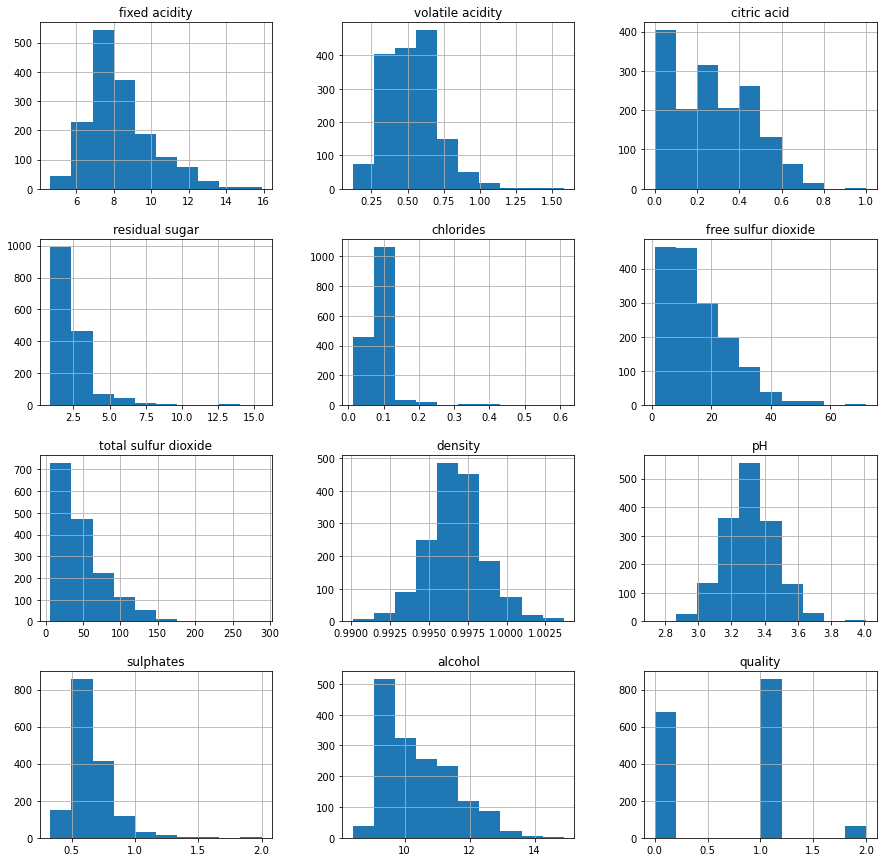

In [26]:
df_red.hist(figsize = (15,15))

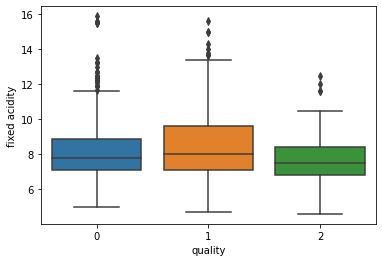

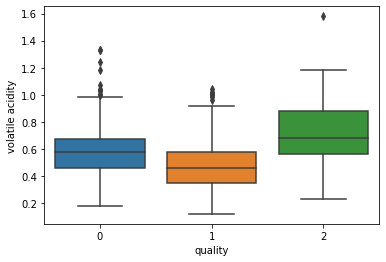

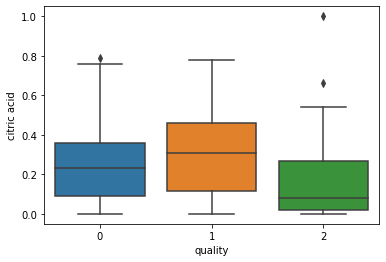

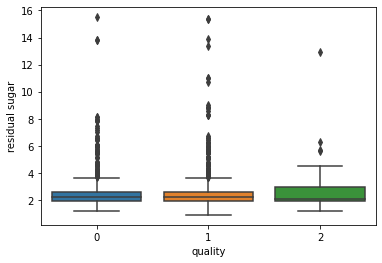

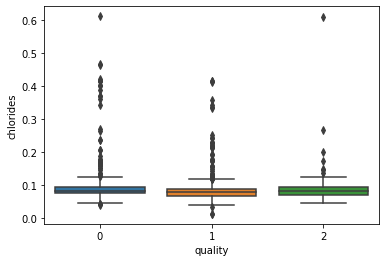

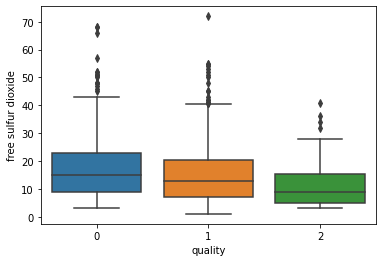

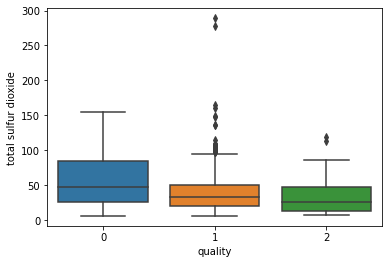

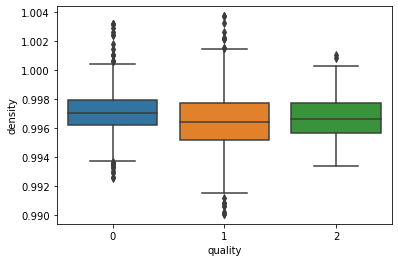

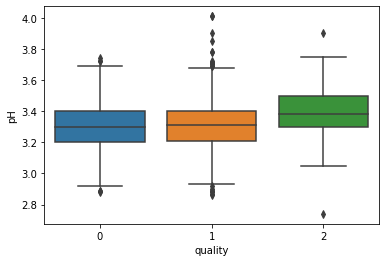

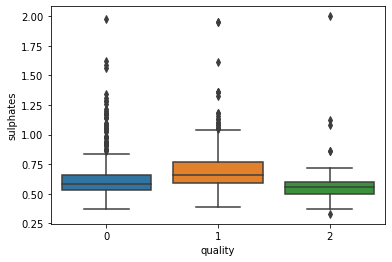

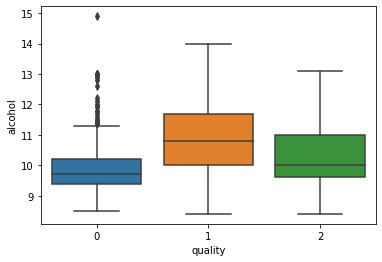

In [29]:
features = df_red.columns
for i in range(1,12):
    sns.boxplot(x='quality', y=features[i-1], data=df_red)
    plt.show()

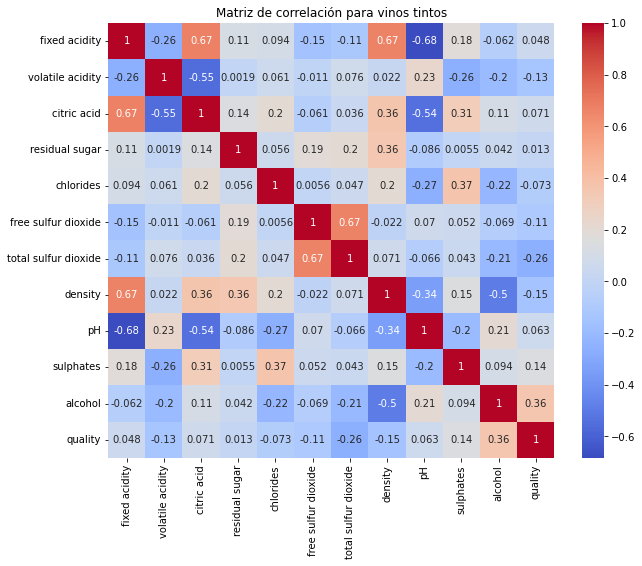

In [27]:
# Matriz de correlación
plt.figure(figsize=(10, 8))
correlation_red = df_red.corr()
sns.heatmap(correlation_red, annot=True, cmap="coolwarm")
plt.title("Matriz de correlación para vinos tintos")
plt.show()

# Preprocesamiento de datos

In [4]:
# Función para categorizar la calidad
def categorize_quality(quality):
    if quality < 5:
        return 'LowQuality'
    elif quality == 5:
        return 'Average'
    else:
        return 'HighQuality'


In [5]:
# Aplicamos la función a los datasets
df_red['quality'] = df_red['quality'].apply(categorize_quality)

In [6]:
# Codificando las etiquetas
le = LabelEncoder()
df_red['quality'] = le.fit_transform(df_red['quality'])

1    53.470919
0    42.589118
2     3.939962
Name: quality, dtype: float64


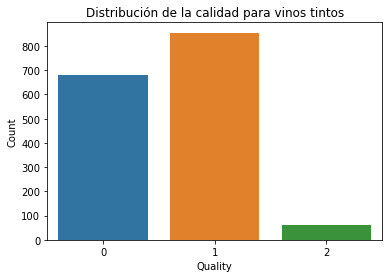

In [7]:
total_samples = len(df_red)
label_counts = df_red['quality'].value_counts()
label_proportions = label_counts / total_samples * 100
print(label_proportions)
plt.figure(figsize=(6, 4))
sns.countplot(x='quality', data=df_red)
plt.title("Distribución de la calidad para vinos tintos")
plt.xlabel("Quality")
plt.ylabel("Count")
plt.show()

In [8]:
minority_classes = [0,2]

In [9]:
minority_data = df_red[df_red['quality'].isin(minority_classes)]
majority_data = df_red[~df_red['quality'].isin(minority_classes)]

In [10]:
n_samples_majority = len(majority_data)

In [11]:
oversampled_data = pd.concat([
    minority_data[minority_data['quality'] == cls].sample(
        n=n_samples_majority, replace=True, random_state=42)
    for cls in minority_classes
])

In [12]:
oversampled_data = pd.concat([oversampled_data, majority_data])

In [13]:
oversampled_redwine_df = shuffle(oversampled_data, random_state=42)

0    33.333333
2    33.333333
1    33.333333
Name: quality, dtype: float64


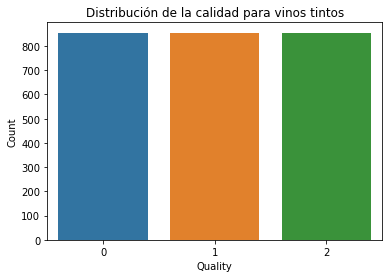

In [14]:
total_samples = len(oversampled_redwine_df)
label_counts = oversampled_data['quality'].value_counts()
label_proportions = label_counts / total_samples * 100
print(label_proportions)

# Distribución de la calidad
plt.figure(figsize=(6, 4))
sns.countplot(x='quality', data=oversampled_redwine_df)
plt.title("Distribución de la calidad para vinos tintos")
plt.xlabel("Quality")
plt.ylabel("Count")
plt.show()

In [15]:
# Separando las características de las etiquetas
X_red = oversampled_redwine_df.drop('quality', axis=1)
y_red = oversampled_redwine_df['quality']

In [16]:
# Escalando las características
scaler = StandardScaler()
X_red = scaler.fit_transform(X_red)

In [17]:
X_red_train, X_red_test, y_red_train, y_red_test = train_test_split(X_red, y_red, test_size=0.2, random_state=42)

# Red neuronal con capa salida función sigmoidal

In [50]:
# Definir el procedimiento de k-fold cross validation
k = 5
kfold = KFold(n_splits=k, shuffle=True, random_state=1)

# Almacenar los puntajes de cada iteración
scores = []
accuracy = []
loss = []
val_loss = []
val_accuracy = []

# Convertir a arrays de NumPy
X_red_np = np.array(X_red)
y_red_np = keras.utils.to_categorical(np.array(y_red))

# Loop para cada fold
for train, test in kfold.split(X_red_np):
    # Crear el modelo
    model = keras.models.Sequential([
        keras.layers.Flatten(input_shape=(X_red_np.shape[1],)),
        keras.layers.Dense(512, activation="relu"),
        keras.layers.Dense(512, activation="relu"),
        keras.layers.Dense(3, activation="sigmoid")
    ])

    # Compilar el modelo
    model.compile(optimizer='adam', 
                  loss='mean_squared_error', 
                  metrics=['accuracy'])

    # Entrenar el modelo en los datos de entrenamiento
    cl = model.fit(X_red_np[train], y_red_np[train], epochs=80, batch_size=32, verbose=0, validation_split=0.2)
    
    accuracy = cl.history['accuracy']
    loss = cl.history['loss']
    val_loss = cl.history['val_loss']
    val_accuracy = cl.history['val_accuracy']
    
    # Evaluar el modelo en los datos de prueba
    score = model.evaluate(X_red_np[test], y_red_np[test], verbose=0)
    scores.append(score[1])  # Asumimos que queremos la métrica 'accuracy'

# Calcular y imprimir el puntaje promedio
average_score = np.mean(scores)
print('Average score:', average_score)

Average score: 0.8674463868141175


17/17 [==============================] - 0s 1ms/step


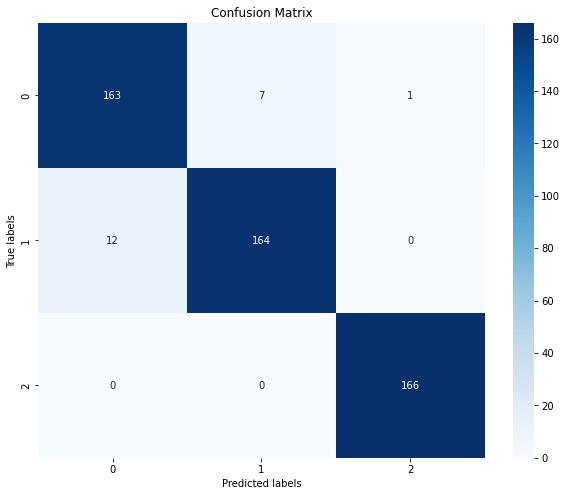

In [55]:
p_test = model.predict(X_red_test).argmax(axis=1)
cm = tf.math.confusion_matrix(y_red_test, p_test)

cm_array = cm.numpy()

# Crear una figura y un eje
fig, ax = plt.subplots(figsize=(10, 8))

# Graficar la matriz de confusión
sns.heatmap(cm_array, annot=True, cmap='Blues', fmt='d', ax=ax)

# Configurar las etiquetas de los ejes
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')

# Mostrar la figura
plt.show()

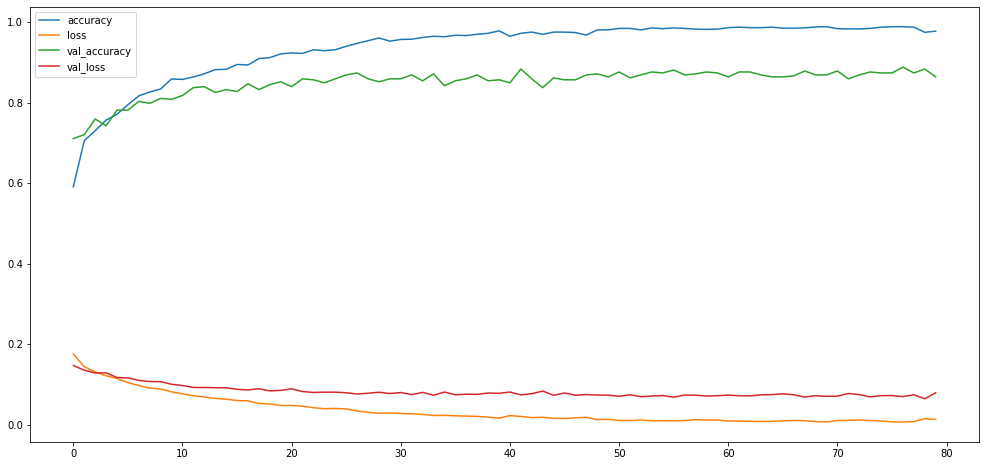

In [52]:
fig, ax = plt.subplots(figsize=(17,8))

plt.plot(accuracy, label='accuracy')
plt.plot(loss,label='loss')
plt.plot(val_accuracy,label='val_accuracy')
plt.plot(val_loss,label='val_loss')
plt.legend()

# Red neuronal con capa salida función tangente hiperbólica

In [53]:
# Definir el procedimiento de k-fold cross validation
k = 5
kfold = KFold(n_splits=k, shuffle=True, random_state=1)

# Almacenar los puntajes de cada iteración
scores = []
accuracy = []
loss = []
val_loss = []
val_accuracy = []

# Convertir a arrays de NumPy
X_red_np = np.array(X_red)
y_red_np = keras.utils.to_categorical(np.array(y_red))

# Loop para cada fold
for train, test in kfold.split(X_red_np):
    # Crear el modelo
    model = keras.models.Sequential([
        keras.layers.Flatten(input_shape=(X_red_np.shape[1],)),
        keras.layers.Dense(512, activation="relu"),
        keras.layers.Dense(512, activation="relu"),
        keras.layers.Dense(3, activation="tanh")
    ])

    # Compilar el modelo
    model.compile(optimizer='adam', 
                  loss='mean_squared_error', 
                  metrics=['accuracy'])

    # Entrenar el modelo en los datos de entrenamiento
    cl = model.fit(X_red_np[train], y_red_np[train], epochs=80, batch_size=32, verbose=0, validation_split=0.2)
    
    accuracy = cl.history['accuracy']
    loss = cl.history['loss']
    val_loss = cl.history['val_loss']
    val_accuracy = cl.history['val_accuracy']
    
    # Evaluar el modelo en los datos de prueba
    score = model.evaluate(X_red_np[test], y_red_np[test], verbose=0)
    scores.append(score[1])  # Asumimos que queremos la métrica 'accuracy'

# Calcular y imprimir el puntaje promedio
average_score = np.mean(scores)
print('Average score:', average_score)

Average score: 0.8842105269432068


17/17 [==============================] - 0s 1ms/step
tf.Tensor(163, shape=(), dtype=int32)


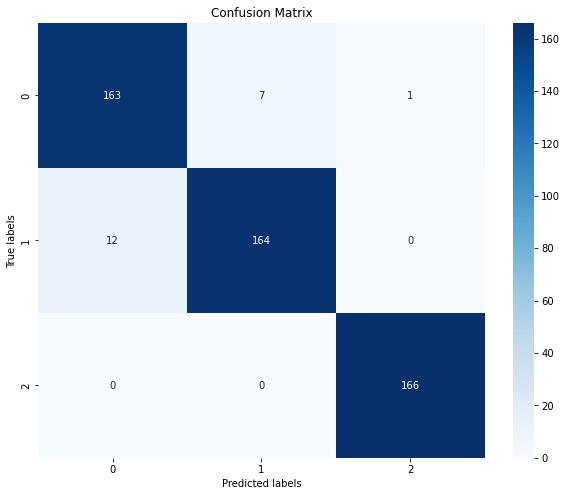

In [54]:
p_test = model.predict(X_red_test).argmax(axis=1)
cm = tf.math.confusion_matrix(y_red_test, p_test)

cm_array = cm.numpy()

# Crear una figura y un eje
fig, ax = plt.subplots(figsize=(10, 8))

# Graficar la matriz de confusión
sns.heatmap(cm_array, annot=True, cmap='Blues', fmt='d', ax=ax)

# Configurar las etiquetas de los ejes
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')

# Mostrar la figura
plt.show()

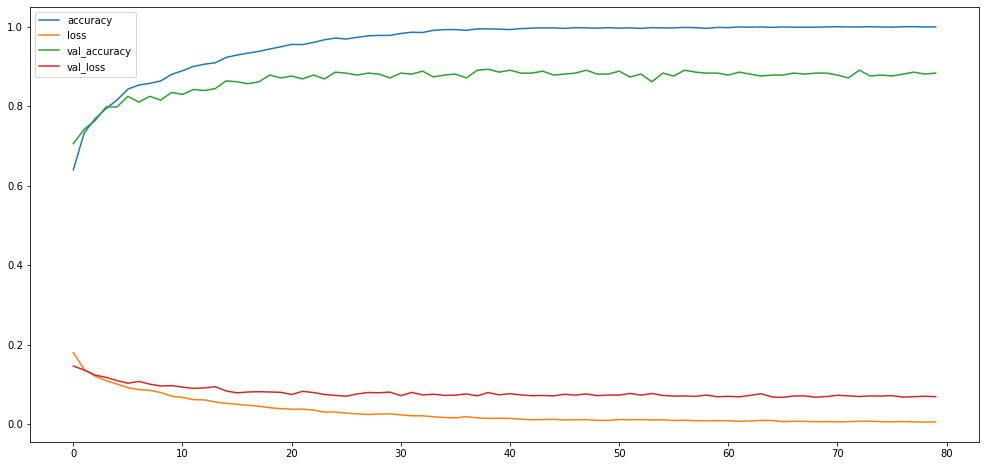

In [56]:
fig, ax = plt.subplots(figsize=(17,8))

plt.plot(accuracy, label='accuracy')
plt.plot(loss,label='loss')
plt.plot(val_accuracy,label='val_accuracy')
plt.plot(val_loss,label='val_loss')
plt.legend()

# Comparación de resultados